# 2D Grid World - Loop Walker - DQN for Invadors adaption

Adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb

### !!! use conda environment: simon

In [1]:
%%script cmd --bg --out asdf
start tensorboard --logdir C:/users/vogi23/checkpoints

In [1]:
import tensorflow as tf
import numpy as np


from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs

from collections import deque# Ordered collection with ends

import random

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
#warnings.filterwarnings('ignore')

import sys
sys.path.append("../packages")

from floorplan.envs.loopwalkercubeworld import LoopWalkerCubeWorldV1

## Creating the Environment

We use V1 which does __not__ terminate on invalid actions.

In [2]:
# Create our environment
env = LoopWalkerCubeWorldV1()

print("The size of our frame is: ", env.observation_space)
print("The action size is : ", env.action_space.n)


# Here we create a hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

The size of our frame is:  Box(2, 24, 24)
The action size is :  4


In [3]:
def preprocess_frame(frame):
    return np.moveaxis(frame, 0, -1)

In [4]:
stack_size = 1 # we do not need to stack frames as in atari

initial_state = env.reset()
single_state_shape = preprocess_frame(initial_state).shape
state_size = list(single_state_shape)
state_size[-1] *= stack_size
print("The single state-shape is : ", single_state_shape)
print("The stacked state-shape is : ", state_size)

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros(single_state_shape, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros(single_state_shape, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        # Because we're in a new episode, copy the same frame x-times
        for _ in range(stack_size):
            stacked_frames.append(frame)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
    
    stacked_state = np.concatenate(list(stacked_frames), axis=2)
    
    return stacked_state, stacked_frames

The single state-shape is :  (24, 24, 2)
The stacked state-shape is :  [24, 24, 2]


In [5]:
### MODEL HYPERPARAMETERS
#state_size = defined above
action_size = env.action_space.n # 4 possible actions
learning_rate =  0.025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 2500            # Total episodes for training
max_steps = 25             # Max possible steps in an episode
batch_size = 256                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
#stack_size = already defined above

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False


In [6]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 16,
                                         kernel_size = [5,5],
                                         strides = [1,1],
                                         padding = "SAME",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 16,
                                 kernel_size = [3,3],
                                 strides = [1,1],
                                 padding = "SAME",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 16,
                                 kernel_size = [3,3],
                                 strides = [1,1],
                                 padding = "SAME",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 128,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [7]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(np.argmax(action))
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    # If the episode is finished
    if done:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

In [9]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [10]:
import datetime
run_path = 'C:/Users/vogi23/checkpoints/'+datetime.datetime.today().strftime('%Y_%m_%d__%H_%M_%S')


# Setup TensorBoard Writer
writer = tf.summary.FileWriter(run_path+'/tb')

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

## epsilon logger
_epsilon = tf.placeholder(tf.float32, [])
tf.summary.scalar("epsilon", _epsilon)

## backStep logger
_backStepCounter = tf.placeholder(tf.float32, [])
tf.summary.scalar("backsteps", _backStepCounter)

write_op = tf.summary.merge_all()

# Saver will help us to save our model
saver = tf.train.Saver()

## Retrain agent

In [11]:
raise Exception('Are you sure to retrain?')

In [10]:
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(np.argmax(action))
                
                if episode_render:
                    env.render()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    # cvn next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    # cvn rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb,
                                                       _epsilon: explore_probability,
                                                       _backStepCounter: env._backStepCounter/step})
                
                
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 200 == 0:
                save_path = saver.save(sess, run_path+'/model/model_e_'+str(episode)+'.ckpt')
                print("Model Saved")

Episode: 0 Total reward: -7.2 Explore P: 0.9995 Training Loss 124.7076
Model Saved
Episode: 1 Total reward: -20.799999999999997 Explore P: 0.9982 Training Loss 1290059.2500
Episode: 2 Total reward: -11.599999999999998 Explore P: 0.9970 Training Loss 5687928.5000
Episode: 3 Total reward: -5.9 Explore P: 0.9965 Training Loss 4093868.5000
Episode: 4 Total reward: -13.799999999999999 Explore P: 0.9952 Training Loss 154362.2656
Episode: 5 Total reward: -24.199999999999996 Explore P: 0.9933 Training Loss 396679.7500
Episode: 6 Total reward: -18.0 Explore P: 0.9923 Training Loss 255631.6562
Episode: 7 Total reward: -17.099999999999998 Explore P: 0.9912 Training Loss 81455.7109
Episode: 8 Total reward: -17.799999999999997 Explore P: 0.9898 Training Loss 10723.4336
Episode: 9 Total reward: -36.0 Explore P: 0.9878 Training Loss 46251.1172
Episode: 10 Total reward: -38.9 Explore P: 0.9858 Training Loss 48589.8398
Episode: 11 Total reward: -7.799999999999999 Explore P: 0.9851 Training Loss 18558.3

## Testing the agent

Simulate one episode with $\epsilon = 0$. Print Q-Values predicted for state-action paris at every timestep and render final result.

Event though the loss decreased monotonically the resulting policy is trivial i.e. _go North_ is predicted constantly

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt
****************************************************
EPISODE  0
530.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
532.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
534.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
536.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
538.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -10.957491 -10.115634]]
540.0 [[ -9.189363 -10.252625 -1

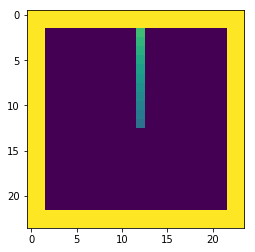

In [11]:
with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, 'C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt')
    
    for episode in range(1):
        total_rewards = 0
        max_steps = 25
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            print(np.sum(state), Qs)
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(np.argmax(action))
            env.render()
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
            if max_steps < 0:
                print ("Abort due to max_steps reached")
                break;
            max_steps -= 1;
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
    #cvn
    plt.imshow(env.render())
    
    env.close()

# Analyzing weights

To find an explanation for the behaviour above, we have a look at the learned weights and biases in our model.

### learned kernels of convolutions 1-16 (only from room-channel)

INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt


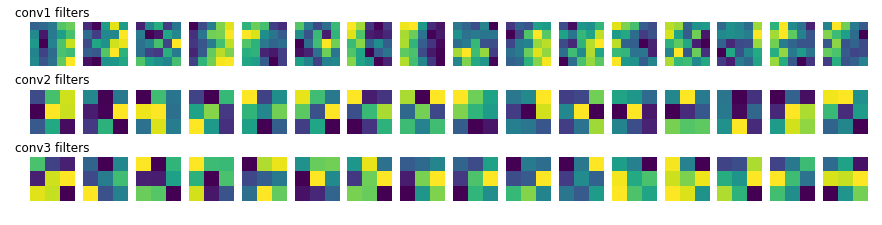

In [65]:
fig, axs = plt.subplots(3,16, figsize=(15,3.5))
[ax.set_axis_off() for ax in axs.ravel()]
with tf.Session() as sess:
    # Load the model
    saver.restore(sess, 'C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt')
    
    conv_kernels = sess.run([tf.global_variables()[0], tf.global_variables()[2], tf.global_variables()[4]])
    for i in range(3):
        for j in range(16):
            axs[i,j].imshow(conv_kernels[i][:,:,1,j])
            if j == 0:
                axs[i,j].set_title('conv%d filters' % (i+1)) 


### Activations after convolutions 1-3

INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt


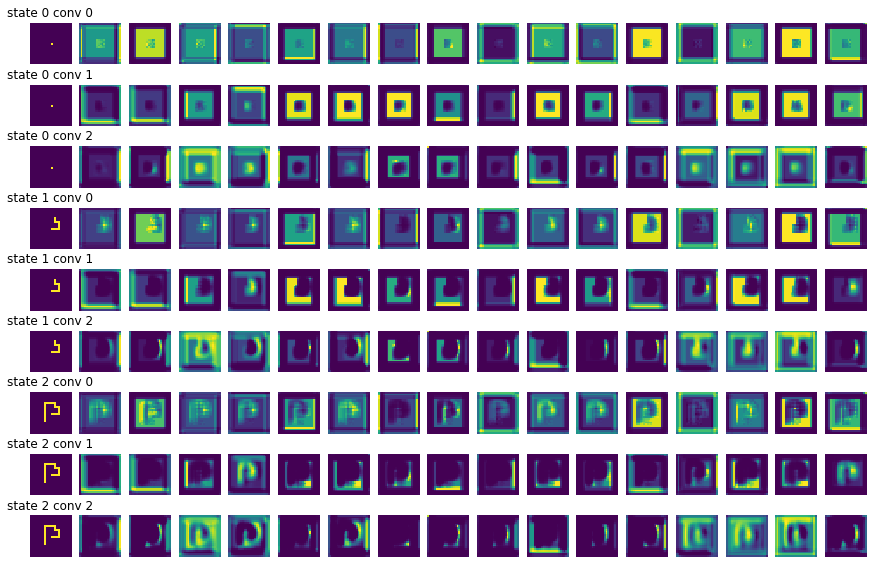

In [63]:
fig, axs = plt.subplots(9,17, figsize=(15,10))
[ax.set_axis_off() for ax in axs.ravel()]
with tf.Session() as sess:
    # Load the model
    saver.restore(sess, 'C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt')
    
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    state0 = np.copy(state)
    
    state1 = np.copy(state)
    state1[12,13:17,1] = env.MAP_WALL # 2x right
    state1[8:12,16,1] = env.MAP_WALL # 2x up
    state1[8,14:17,1] = env.MAP_WALL # 1x left
    state1[6:8,14,1] = env.MAP_WALL # 1x up
    state1[12,12,0] = env.MAP_EMPTY # current position
    state1[6,14,0] = env.MAP_POSITION # current position
    
    state2 = np.copy(state1)
    state2[6,8:14,1] = env.MAP_WALL # 3x left
    state2[6:17,8,1] = env.MAP_WALL # 3x down
    state2[12,12,0] = env.MAP_EMPTY # current position
    state2[16,12,0] = env.MAP_POSITION # current position
    
    convs = sess.run([DQNetwork.conv1_out, DQNetwork.conv2_out, DQNetwork.conv3_out], feed_dict = {DQNetwork.inputs_: np.stack([state0, state1,state2])})
    
    states = [state0, state1, state2]
    
    for s in range(3):
        for c in range(3):
            axs[c+3*s,0].imshow(states[s][:,:,1])
            axs[c+3*s,0].set_title('state '+str(s)+' conv '+str(c))
            for f in range(16):
                axs[c+3*s,f+1].imshow(convs[c][s,:,:,f])

### Activations after fully connected and output

INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt
[[ -9.189363 -10.252623 -10.95749  -10.115633]
 [ -9.189363 -10.252623 -10.95749  -10.115633]
 [ -9.189363 -10.252623 -10.95749  -10.115633]]


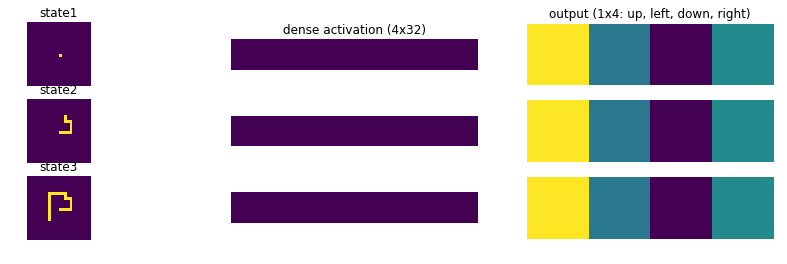

In [111]:
fig, axs = plt.subplots(3,3, figsize=(15,4))
[ax.set_axis_off() for ax in axs.ravel()]
with tf.Session() as sess:
    # Load the model
    saver.restore(sess, 'C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt')
    
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    state0 = np.copy(state)
    
    state1 = np.copy(state)
    state1[12,13:17,1] = env.MAP_WALL # 2x right
    state1[8:12,16,1] = env.MAP_WALL # 2x up
    state1[8,14:17,1] = env.MAP_WALL # 1x left
    state1[6:8,14,1] = env.MAP_WALL # 1x up
    state1[12,12,0] = env.MAP_EMPTY # current position
    state1[6,14,0] = env.MAP_POSITION # current position
    
    state2 = np.copy(state1)
    state2[6,8:14,1] = env.MAP_WALL # 3x left
    state2[6:17,8,1] = env.MAP_WALL # 3x down
    state2[12,12,0] = env.MAP_EMPTY # current position
    state2[16,12,0] = env.MAP_POSITION # current position
        
    axs[0,0].imshow(state0[:,:,1])
    axs[0,0].set_title('state1')
    axs[1,0].imshow(state1[:,:,1])
    axs[1,0].set_title('state2')
    axs[2,0].imshow(state2[:,:,1])
    axs[2,0].set_title('state3')
    fc, q = sess.run([DQNetwork.fc, DQNetwork.output], feed_dict = {DQNetwork.inputs_: np.stack([state0, state1, state2])})
    axs[0,1].imshow(fc[0].reshape((4,32)))
    axs[0,1].set_title('dense activation (4x32)')
    axs[0,2].imshow(q[0].reshape((1,4)))
    axs[0,2].set_title('output (1x4: up, left, down, right)')
    axs[1,1].imshow(fc[1].reshape((4,32)))
    axs[1,2].imshow(q[1].reshape((1,4)))
    axs[2,1].imshow(fc[2].reshape((4,32)))
    axs[2,2].imshow(q[2].reshape((1,4)))
    
    print(q)


Activations after first fully connected layer seem to absorb all information.

### Neural model predicts constant q-values?

Simulate 100 episodes with random action selection to make sure if there really are no states which lead to another action

In [17]:

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, 'C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt')
    qs = []
    
    for episode in range(100):
        max_steps = 25
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            qs.append(Qs)
            
            # Take random walk
            choice = np.random.randint(0,4) 
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(np.argmax(action))
            env.render()
            
            total_rewards += reward

            if done or max_steps < 0:
                break
            max_steps -= 1;
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state    


INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/2019_05_07__16_55_51/model/model_e_2400.ckpt


In [18]:
print('Number of steps taken: ', len(qs))
[print('action ', i, ' unique predicted values: ', len(np.unique(np.concatenate(qs)[:,i]))) for i,ax in enumerate(axs)]
None

Number of steps taken:  1476
action  0  unique predicted values:  1
action  1  unique predicted values:  1
action  2  unique predicted values:  1
action  3  unique predicted values:  1


Again constant predictions for each action

In [19]:
print('count distinct unique actions: ', np.unique(np.argmax(np.concatenate(qs), axis=1)))

count distinct unique actions:  [0]


## "class" imbalance

We look at the memory-buffer at the end of training (after about 2400 episodes). A majority of the observed rewards is 0 (each non-terminal and non invalid step). A second big proportion has a reward of -3 (which are the invalid moves). This class imbalance might be an explanation why the training _collapses_ and the predictor just predicts constant values.

See Report fur further analysis

In [24]:
import pandas as pd
print('action distribution')
print(pd.value_counts([np.argmax(e[1]) for e in memory.buffer]))
print('reward distribution')
print(pd.value_counts([e[2] for e in memory.buffer]))
print('overall average reward for terminal rewards', np.mean([e[2] for e in memory.buffer if e[4] is True]))
print('overall average reward for non terminal rewards', np.mean([e[2] for e in memory.buffer if e[4] is False]))

action distribution
0    14159
1    13501
3    11209
2    11026
dtype: int64
reward distribution
 0.0     28854
-3.0     19683
-4.2        45
-7.9        33
-3.4        29
-7.2        26
-4.3        26
-2.6        22
-9.7        22
-7.1        22
-3.5        20
-6.1        20
-6.0        20
-8.0        20
-5.2        19
-11.3       18
-6.2        18
-5.4        18
-5.3        18
-2.7        18
-7.8        17
-8.1        16
-9.6        14
-9.8        14
-7.0        13
-6.3        13
-4.4        13
-5.0        12
-4.5        12
-5.9        12
         ...  
-16.1        1
-10.0        1
-10.9        1
-6.6         1
-14.9        1
-23.4        1
-0.2         1
-13.8        1
-7.5         1
-12.2        1
-19.7        1
-9.9         1
-14.1        1
-1.8         1
-11.3        1
-3.7         1
 0.2         1
-10.5        1
-2.3         1
-6.7         1
-12.5        1
-14.5        1
-1.0         1
-12.7        1
-15.1        1
-12.9        1
-21.4        1
-1.4         1
-8.4         1
-8.